In [ ]:
# -	Accuracy
# -	Precision
# -	Recall
# -	F1 score
# -	ROC
# -	AUC


In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns 
from PIL import Image
import pickle
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
!pip install yellowbrick

# Import Test Data

In [208]:
# Declare training path
test_path = './gtsrb-dataset/Test'
test_id_path = './gtsrb-dataset/Test.csv'

# Declare arrays to store test images and labels
test_x = []
test_y =[]

# Read in true lables form csv file
test = pd.read_csv(test_id_path)
test_y = test["ClassId"].values

# Load images, resize and store in an array
for img in os.listdir(test_path):
    im = Image.open(test_path +'/'+ img)
    im = im.resize((32,32))
    im = np.array(im)
    test_x.append(im)
test_x = np.array(test_x)

In [209]:
len(test_x)

12630

In [210]:
len(test_y)

12630

# Import Out of Sample Images

In [134]:
# Declare training path
test_path = './out-of-sample'

# Declare arrays to store test images and labels
test_x_1 = []

# Load images, resize and store in an array
for img in os.listdir(test_path):
    im = Image.open(test_path +'/'+ img)
    im = im.resize((32,32))
    im = np.array(im)
    test_x_1.append(im)
test_x_1 = np.array(test_x_1)

In [135]:
len(test_x_1)

5

In [152]:
test_y_1 = [1,36,14,25,40]

In [31]:
CLASS_LABELS = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

# Import Models

In [2]:
model_v1 = keras.models.load_model('CNN_version1.h5')
model_v2 = keras.models.load_model('CNN_version2_grey_norm.h5')
model_v3 = keras.models.load_model('CNN_version3_grey_tuned.h5')
model_v4 = keras.models.load_model('CNN_version4_data_aug.h5')

# Performance Testing

In [116]:
# Convert to Grayscale and Normalise
def setGrayAndNormalise(img):
  img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  equ  = cv2.equalizeHist(img_gray)
  norm = equ/255  
  return norm

# Call function on each image in the testing set 
test_x = np.array([setGrayAndNormalise(img) for img in test_x])

# Reshape test data to match input shape of model
test_x= np.reshape(test_x, (
test_x.shape[0], test_x.shape[1], test_x.shape[2],1))

## Helper functions

In [129]:
from sklearn.metrics import accuracy_score
# Predict classes for test data
pred = np.argmax(model_v4.predict(test_x), axis=-1)

# Dsiplay accuracy with the test data
print('Test Data accuracy: ',accuracy_score(test_y, pred)*100)

395/395 [==============================] - 1s 2ms/step
Test Data accuracy:  93.78463974663501


In [130]:
from sklearn.metrics import classification_report

print(classification_report(test_y,pred))

              precision    recall  f1-score   support

           0       0.97      0.58      0.73        60
           1       0.95      0.97      0.96       720
           2       0.95      0.97      0.96       750
           3       0.93      0.95      0.94       450
           4       0.92      0.96      0.94       660
           5       0.96      0.83      0.89       630
           6       0.98      0.61      0.75       150
           7       0.98      0.83      0.90       450
           8       0.86      0.94      0.90       450
           9       0.98      1.00      0.99       480
          10       0.99      0.99      0.99       660
          11       0.94      0.92      0.93       420
          12       0.98      1.00      0.99       690
          13       0.99      1.00      0.99       720
          14       1.00      0.91      0.95       270
          15       0.63      0.99      0.77       210
          16       1.00      0.99      1.00       150
          17       1.00    

ROC AUC score: 0.9555851971006225


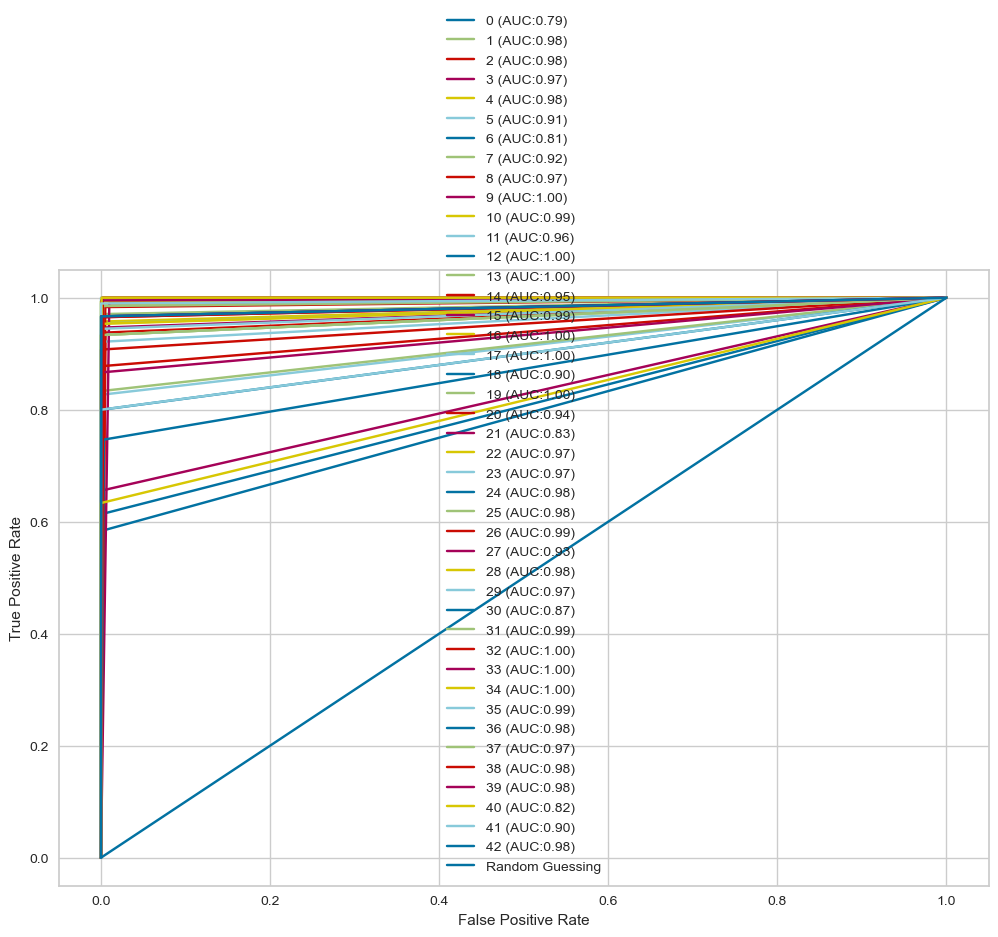

In [131]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(test_y, pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [145]:
# Call function on each image in the testing set 
test_x_1 = np.array([setGrayAndNormalise(img) for img in test_x_1])

# Reshape test data to match input shape of model
test_x_1= np.reshape(test_x_1, (
test_x_1.shape[0], test_x_1.shape[1], test_x_1.shape[2],1))

In [147]:
# Predict classes for test data
pred = np.argmax(model_v3.predict(test_x_1), axis=-1)

1/1 [==============================] - 0s 54ms/step


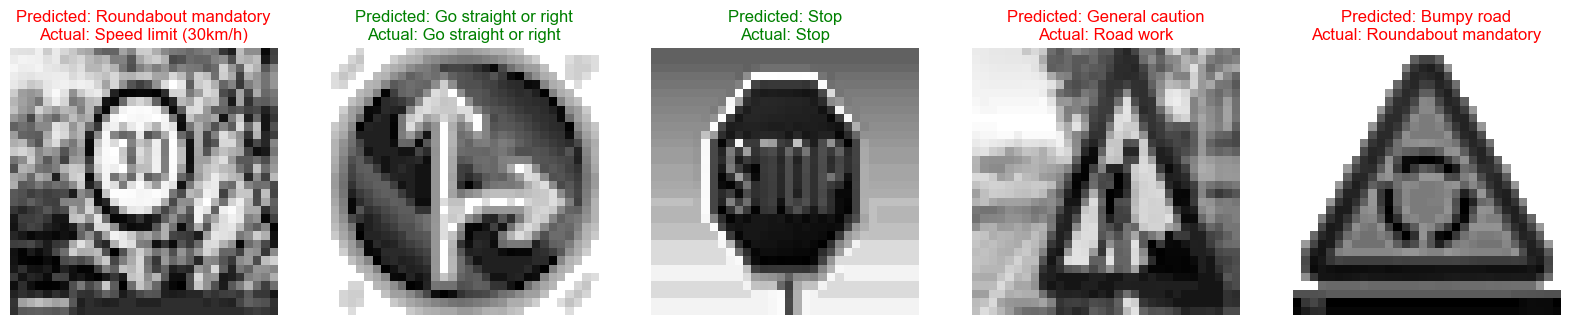

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_x_1[i].squeeze(), cmap='gray')
    if test_y_1[i] == pred[i]:
        ax.set_title('Predicted: '+CLASS_LABELS[pred[i]]+ '\nActual: '+CLASS_LABELS[test_y_1[i]], color='green')
    else:
        ax.set_title('Predicted: '+CLASS_LABELS[pred[i]]+ '\nActual: '+CLASS_LABELS[test_y_1[i]], color='red')   
    ax.axis('off')
plt.show()

# Full-Coverage Testing

In [203]:
def load_images(csv_file_path, image_dir_path):
    df = pd.read_csv(csv_file_path)
    class_ids = df['ClassId'].unique()
    images = []
    
    for class_id in class_ids:
        img_path = df[df['ClassId'] == class_id]['Path'].iloc[0]
        im = Image.open(image_dir_path +'/'+ img_path)
        im = im.resize((32,32))
        im = np.array(im)
        images.append(im)
    
    return images, class_ids

test_full, class_ids = load_images("./gtsrb-dataset/Test.csv", './gtsrb-dataset/')
test_full = np.array(test_full)


In [204]:
len(test_full)

43

In [205]:
len(class_ids)

43

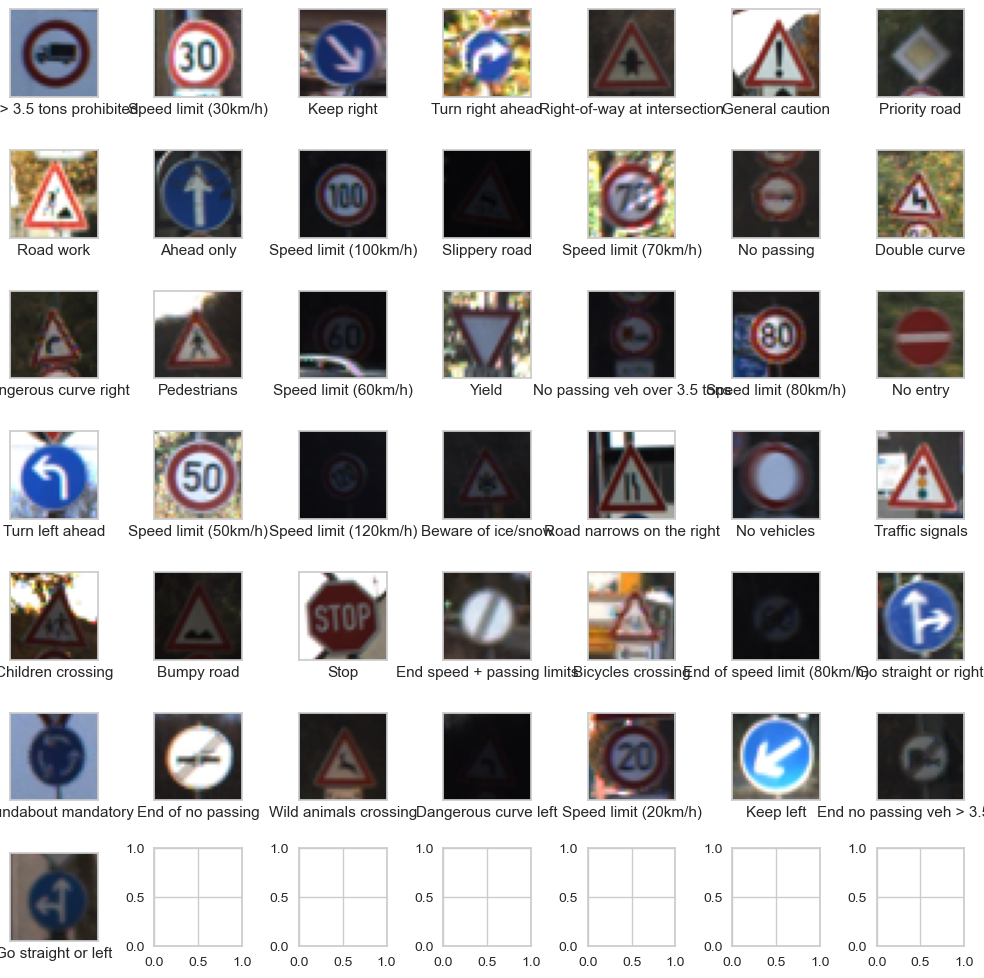

In [206]:
# Create a figure with 7 rows and 7 columns
fig, ax = plt.subplots(nrows=7, ncols=7, figsize=(10, 10))

# Iterate over the first 43 images in the test_full array
for i in range(43):
    # Get the current axis to plot the image
    row = i // 7
    col = i % 7
    current_ax = ax[row][col]
    
    # Plot the image
    current_ax.imshow(test_full[i])
    
    # Set the label for the current image
    label = CLASS_LABELS[class_ids[i]]
    current_ax.set_xlabel(label)
    
    # Remove ticks from the axis
    current_ax.set_xticks([])
    current_ax.set_yticks([])
    
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(test_full[i].squeeze(), cmap='binary')
    if class_ids[i] == pred[i]:
        ax.set_title('Predicted: '+CLASS_LABELS[pred[i]]+ '\nActual: '+CLASS_LABELS[class_ids[i]], color='green')
    else:
        ax.set_title('Predicted: '+CLASS_LABELS[pred[i]]+ '\nActual: '+CLASS_LABELS[class_ids[i]], color='red')   
    ax.axis('off')
plt.show()

1/1 [==============================] - 0s 490ms/step


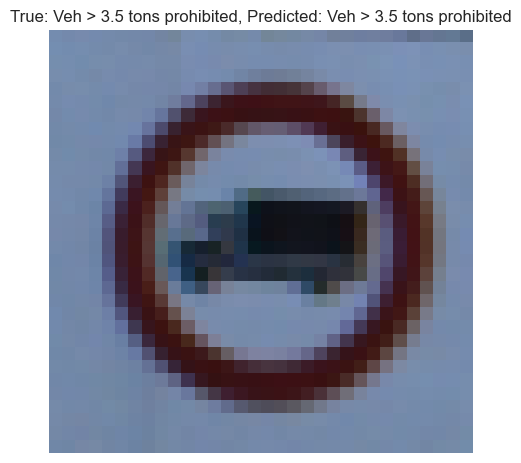

1/1 [==============================] - 0s 21ms/step


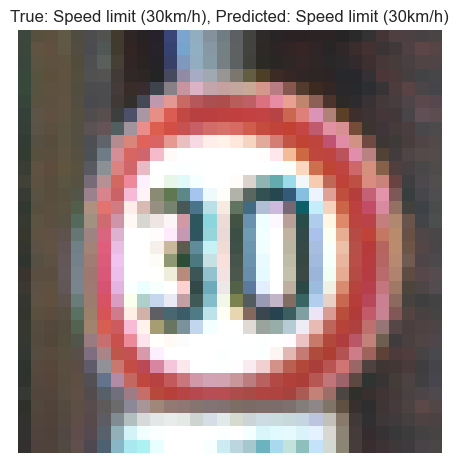

1/1 [==============================] - 0s 19ms/step


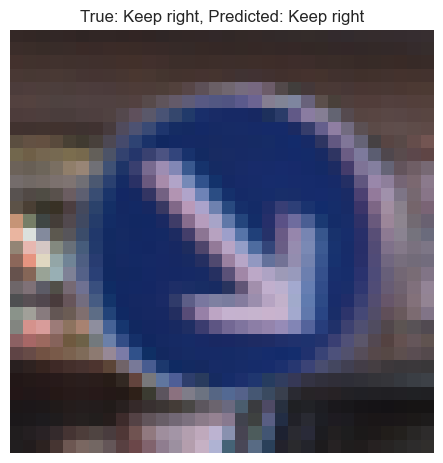

1/1 [==============================] - 0s 21ms/step


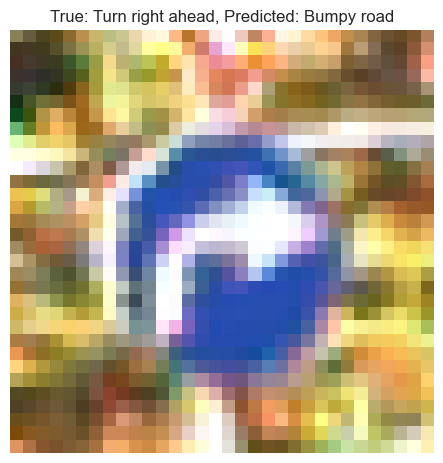

1/1 [==============================] - 0s 20ms/step


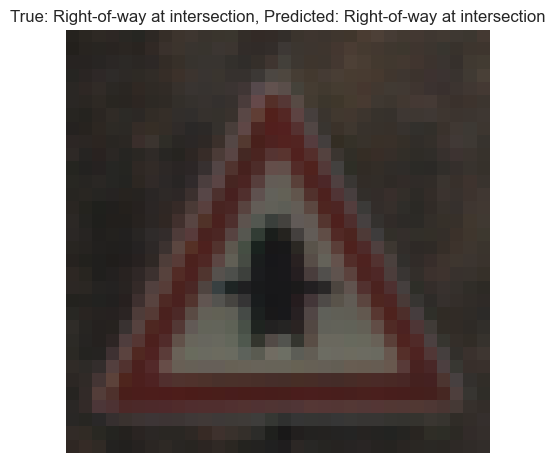

1/1 [==============================] - 0s 20ms/step


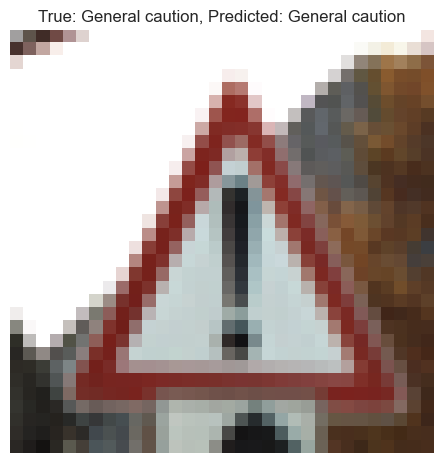

1/1 [==============================] - 0s 20ms/step


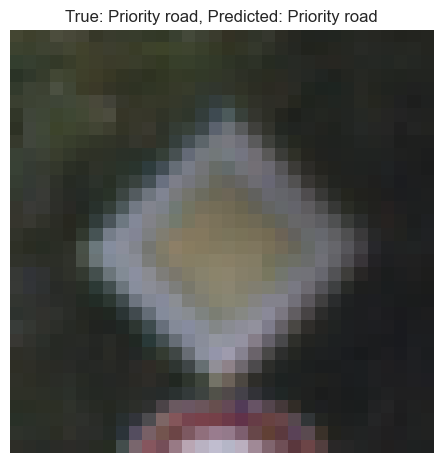

1/1 [==============================] - 0s 20ms/step


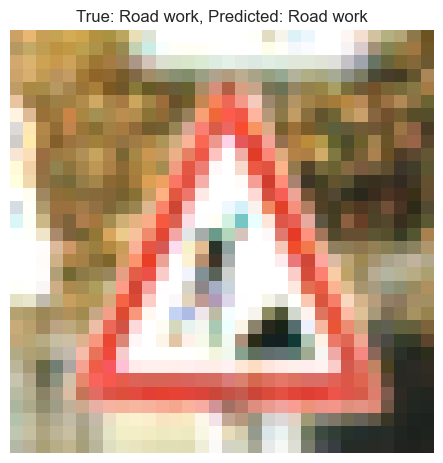

1/1 [==============================] - 0s 21ms/step


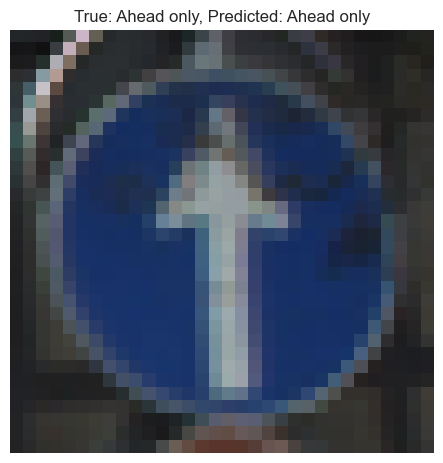

1/1 [==============================] - 0s 19ms/step


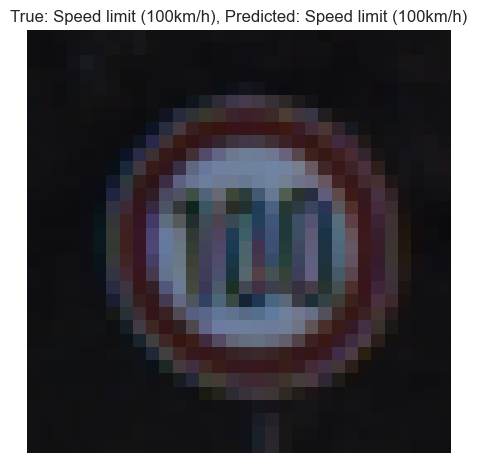

1/1 [==============================] - 0s 20ms/step


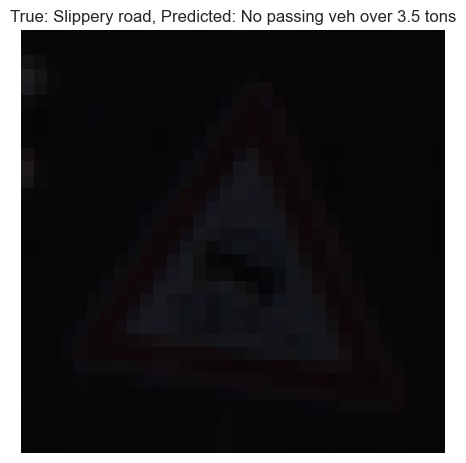

1/1 [==============================] - 0s 19ms/step


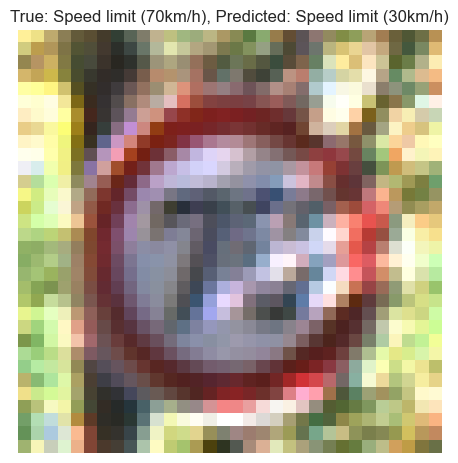

1/1 [==============================] - 0s 20ms/step


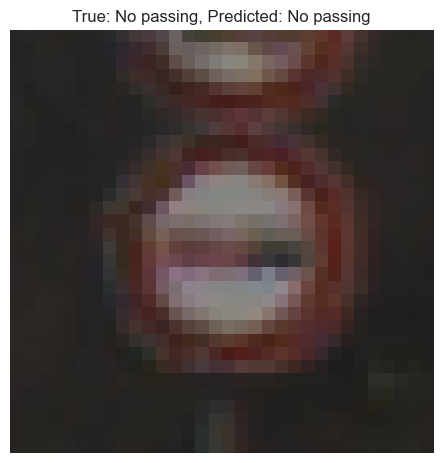

1/1 [==============================] - 0s 21ms/step


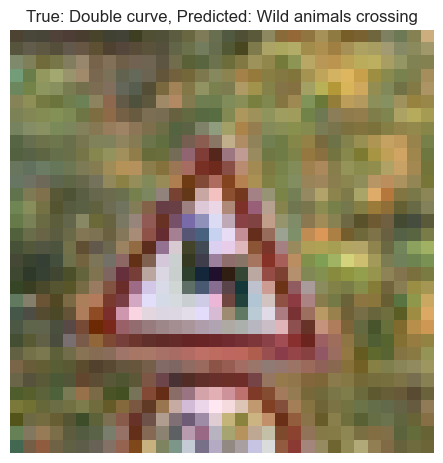

1/1 [==============================] - 0s 21ms/step


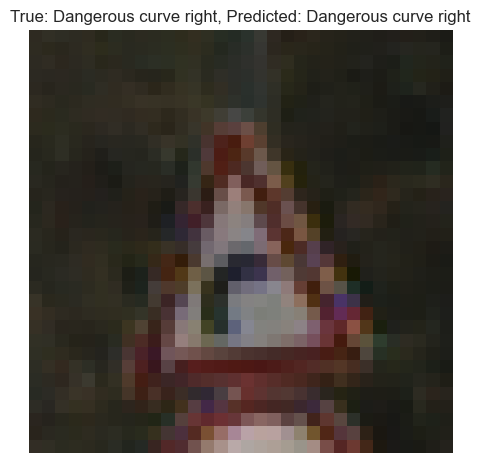

1/1 [==============================] - 0s 21ms/step


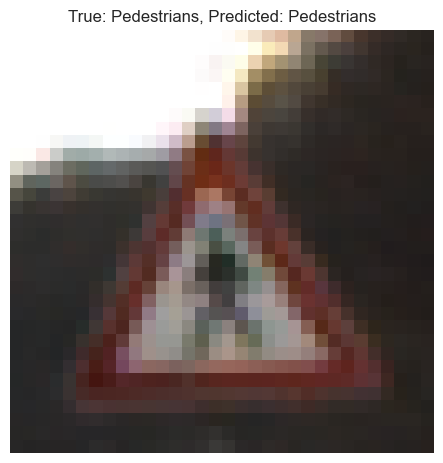

1/1 [==============================] - 0s 20ms/step


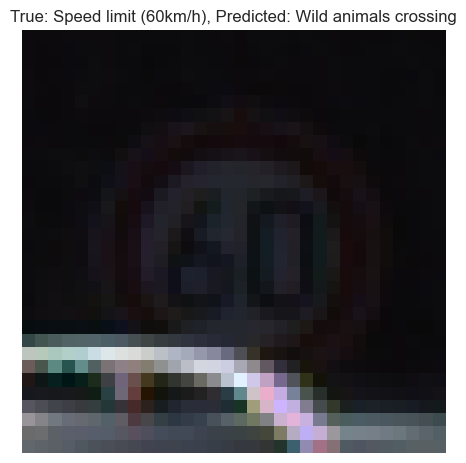

1/1 [==============================] - 0s 20ms/step


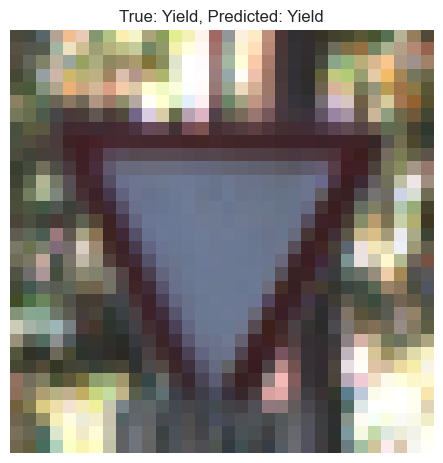

1/1 [==============================] - 0s 20ms/step


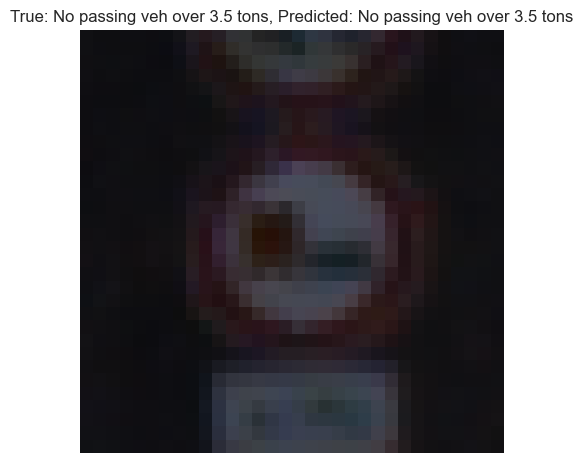

1/1 [==============================] - 0s 20ms/step


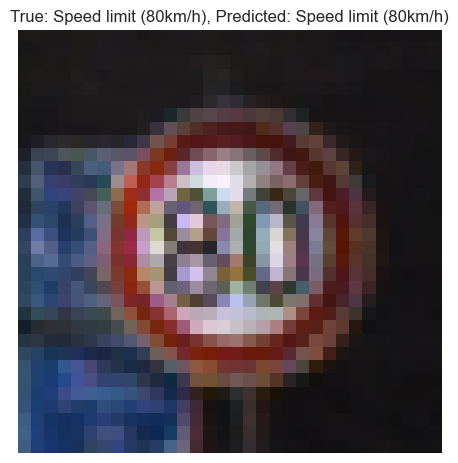

1/1 [==============================] - 0s 19ms/step


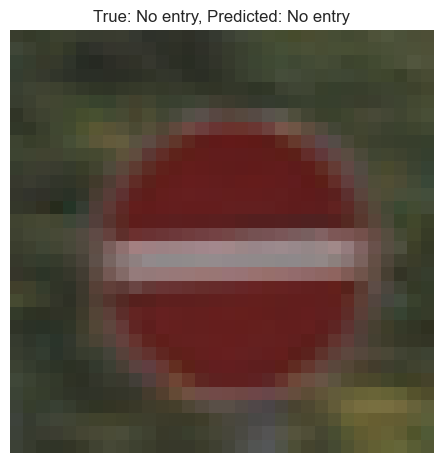

1/1 [==============================] - 0s 21ms/step


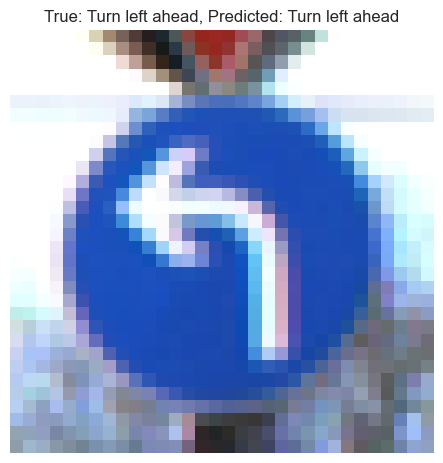

1/1 [==============================] - 0s 20ms/step


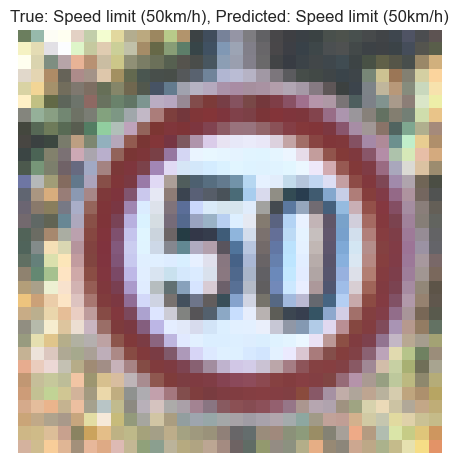

1/1 [==============================] - 0s 20ms/step


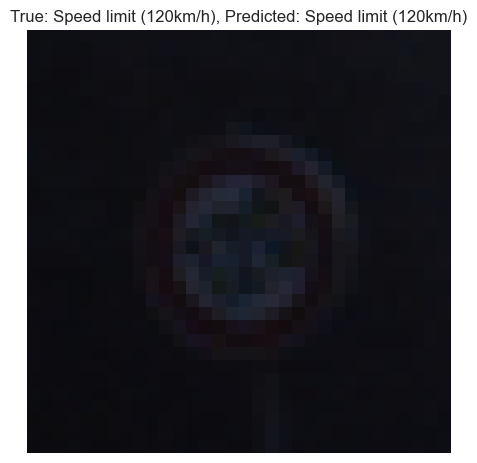

1/1 [==============================] - 0s 21ms/step


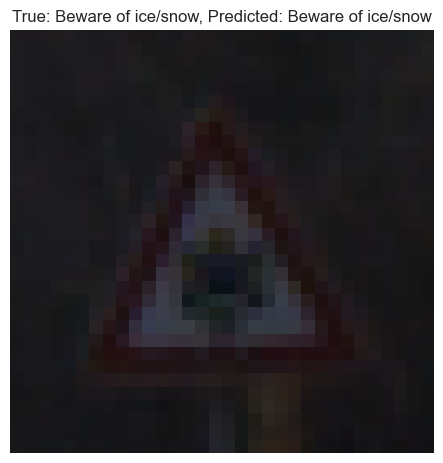

1/1 [==============================] - 0s 22ms/step


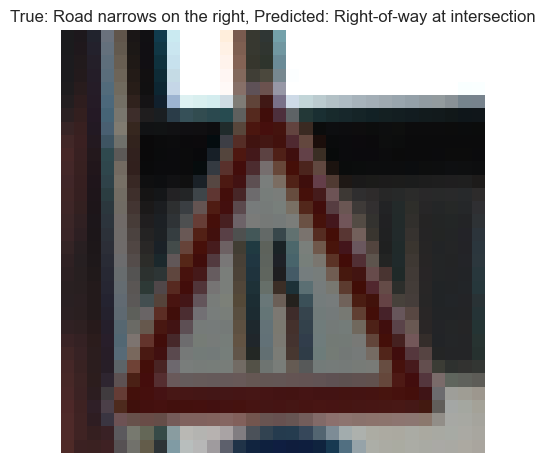

1/1 [==============================] - 0s 22ms/step


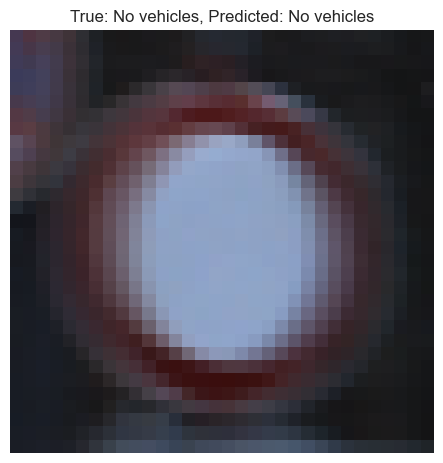

1/1 [==============================] - 0s 19ms/step


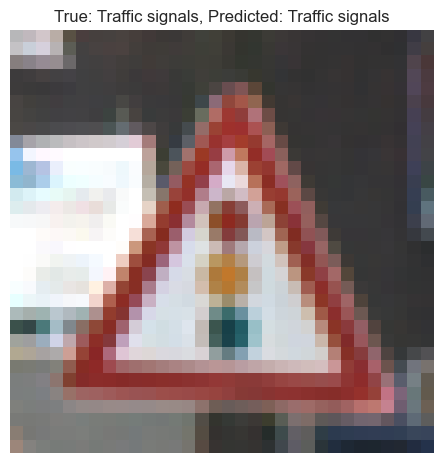

1/1 [==============================] - 0s 21ms/step


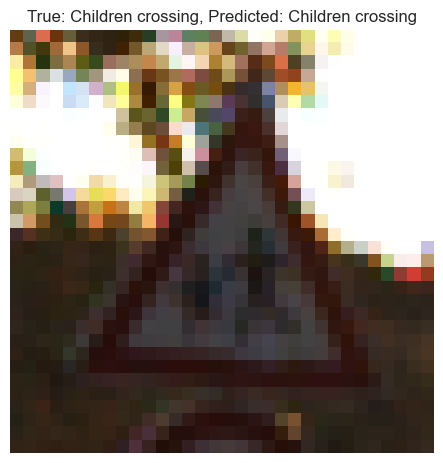

1/1 [==============================] - 0s 21ms/step


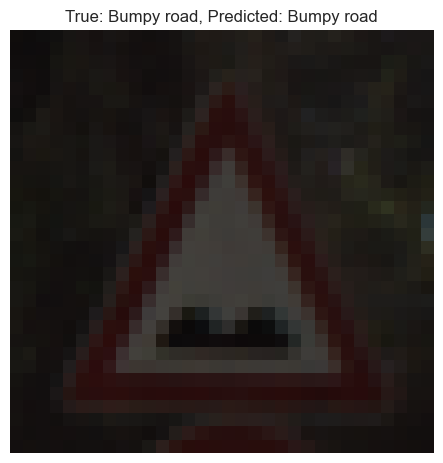

1/1 [==============================] - 0s 21ms/step


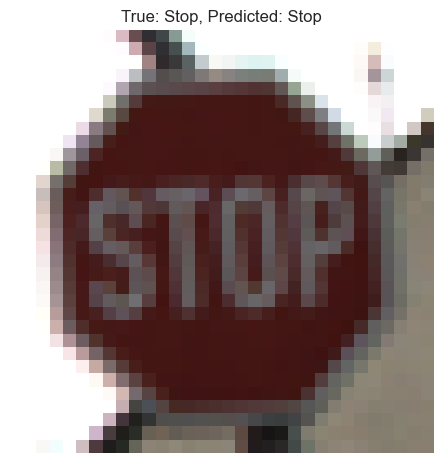

1/1 [==============================] - 0s 20ms/step


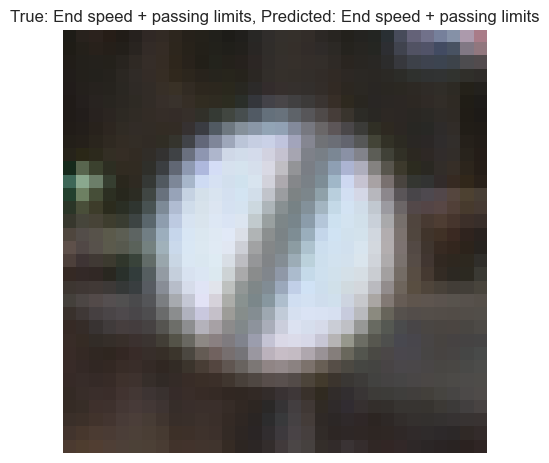

1/1 [==============================] - 0s 20ms/step


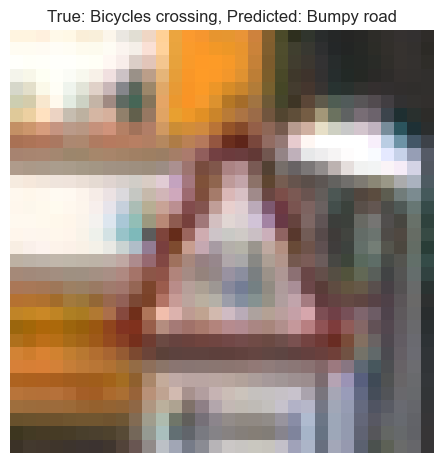

1/1 [==============================] - 0s 21ms/step


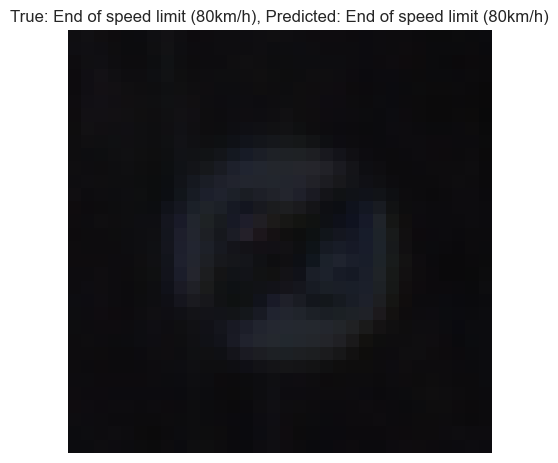

1/1 [==============================] - 0s 22ms/step


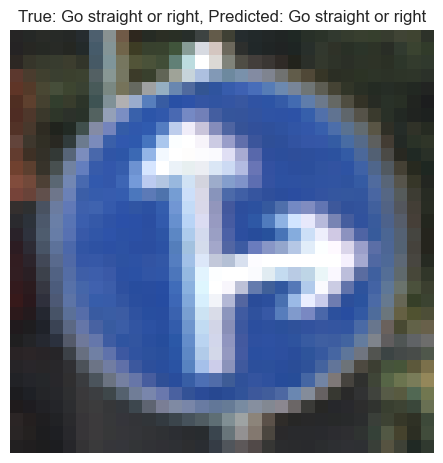

1/1 [==============================] - 0s 20ms/step


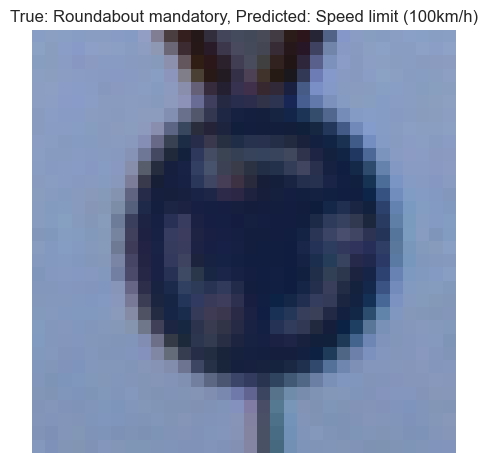

1/1 [==============================] - 0s 19ms/step


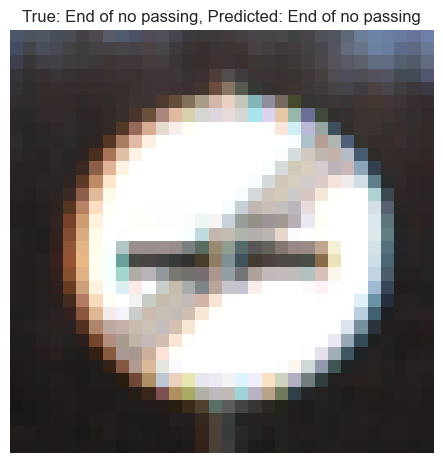

1/1 [==============================] - 0s 20ms/step


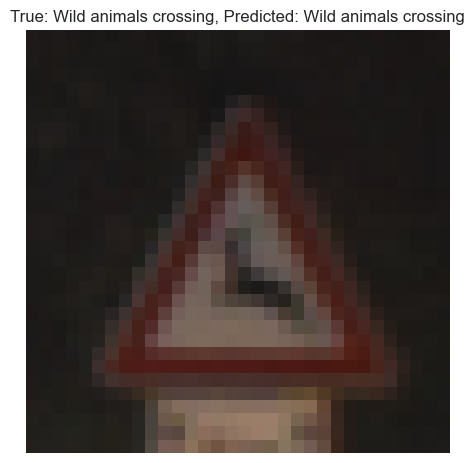

1/1 [==============================] - 0s 20ms/step


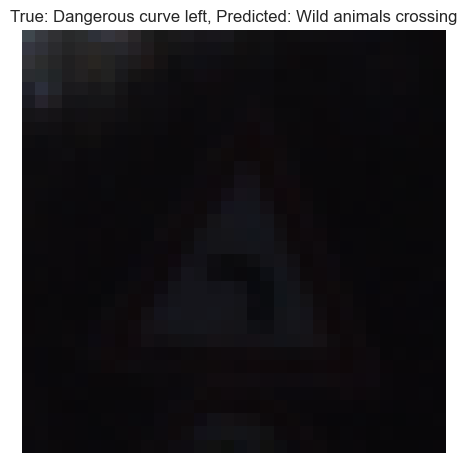

1/1 [==============================] - 0s 20ms/step


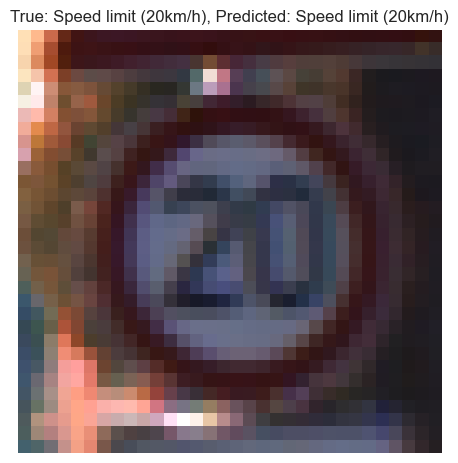

1/1 [==============================] - 0s 20ms/step


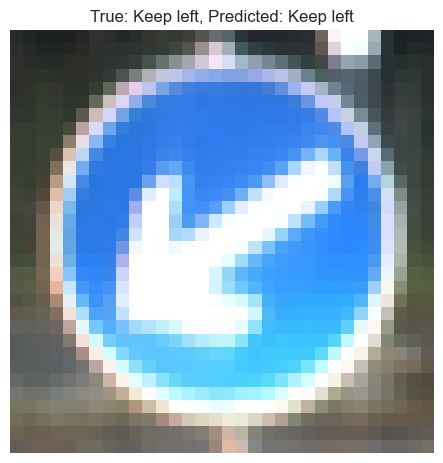

1/1 [==============================] - 0s 19ms/step


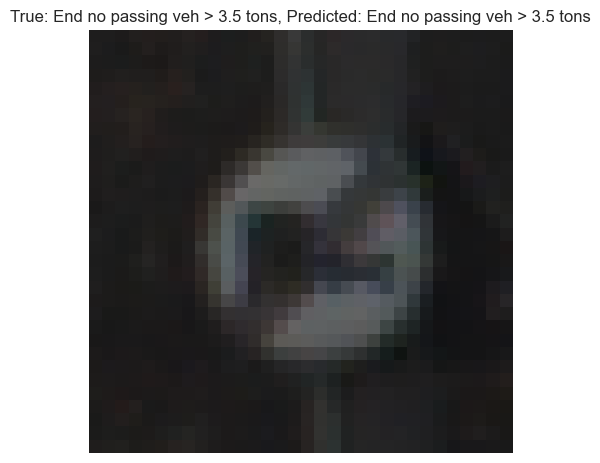

1/1 [==============================] - 0s 19ms/step


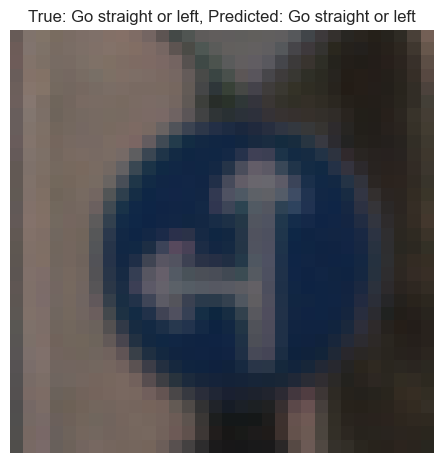

In [188]:
for i in range(len(test_full)):
    # Get predicted class for image i
    pred_class = np.argmax(model_v1.predict(test_full[i:i+1]), axis=-1)[0]
    
    # Get true class for image i
    true_class = class_ids[i]
    
    # Plot image i with predicted and true labels
    plt.imshow(test_full[i])
    plt.title(f"True: {CLASS_LABELS[true_class]}, Predicted: {CLASS_LABELS[pred_class]}")
    plt.axis("off")
    plt.show()

In [199]:
# Call function on each image in the testing set 
test_full = np.array([setGrayAndNormalise(img) for img in test_full])

# Reshape test data to match input shape of model
test_full= np.reshape(test_full, (
test_full.shape[0], test_full.shape[1], test_full.shape[2],1))

1/1 [==============================] - 0s 19ms/step


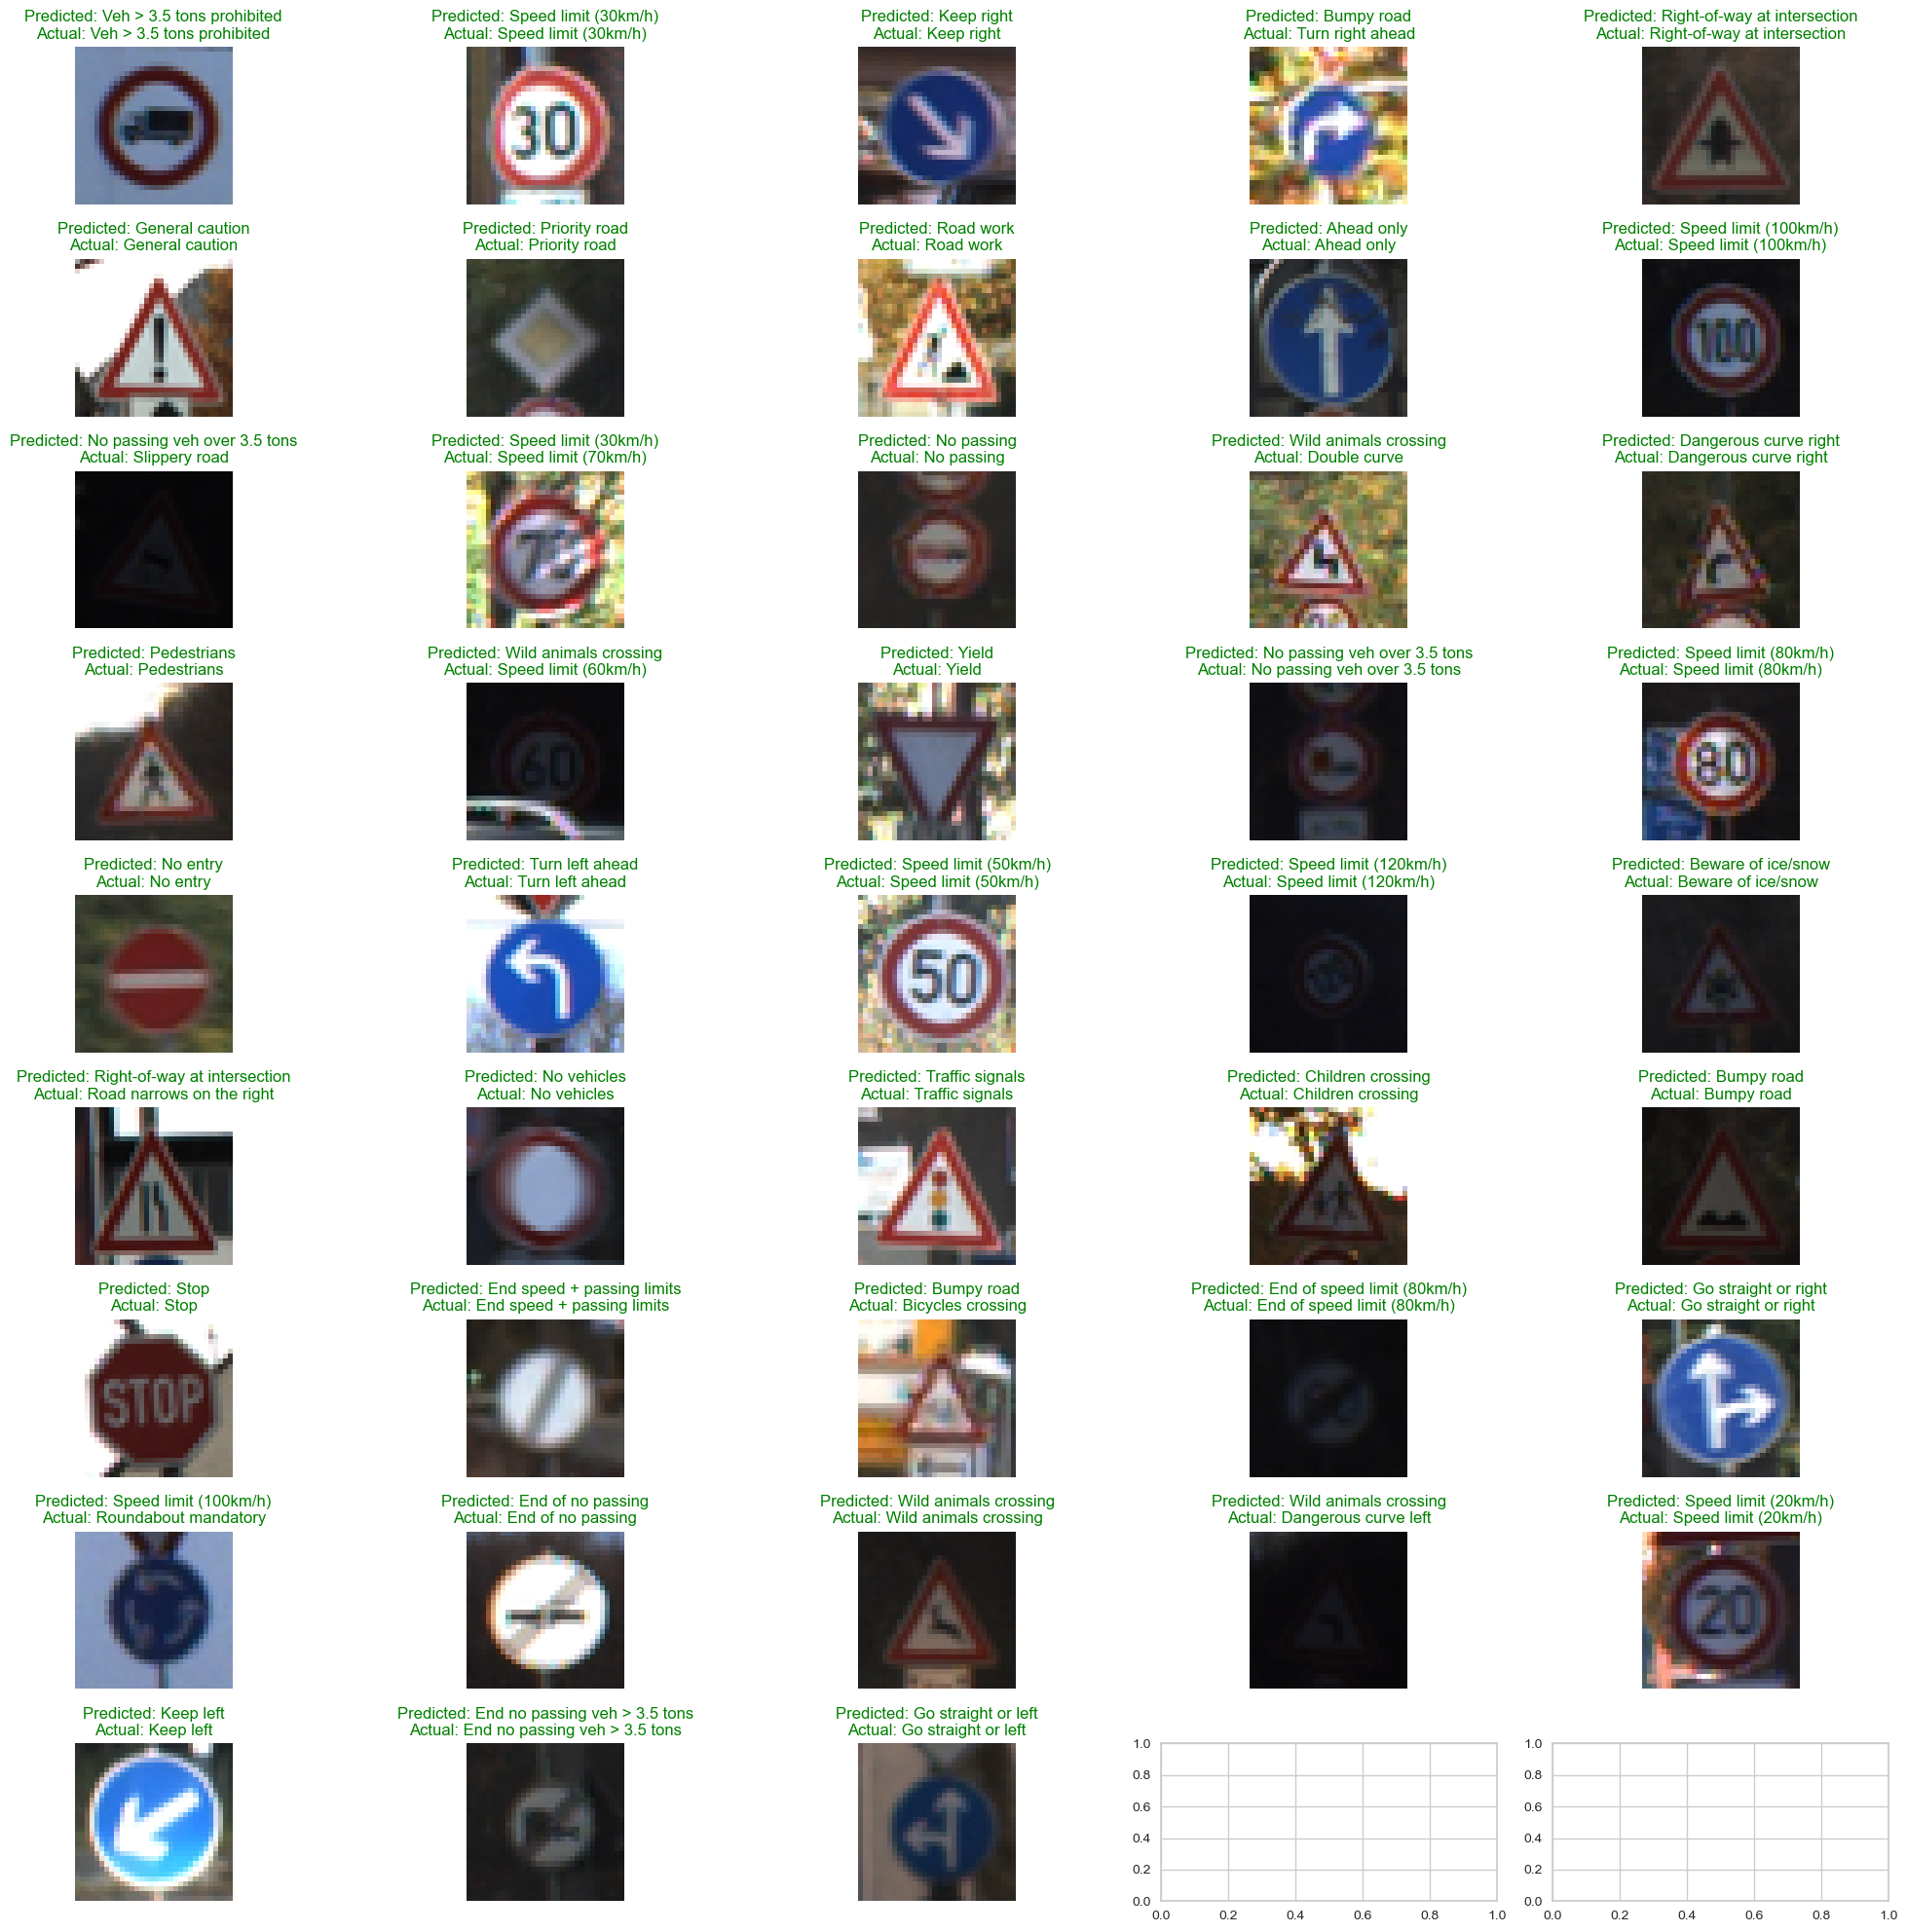

In [207]:
num_images = len(test_full)
num_cols = 2
num_rows = (num_images + num_cols - 1) // num_cols

fig, axes = plt.subplots(9, 5, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        # Get predicted class for image i
        pred_class = np.argmax(model_v1.predict(test_full[i:i+1]), axis=-1)[0]

        # Get true class for image i
        true_class = class_ids[i]

        # Plot image i with predicted and true labels
        ax.imshow(test_full[i])
#         ax.set_title(f"True: {CLASS_LABELS[true_class]}, \nPredicted: {CLASS_LABELS[pred_class]}")
        
        if class_ids[i] == true_class:
            ax.set_title('Predicted: '+CLASS_LABELS[pred_class]+ '\nActual: '+CLASS_LABELS[true_class], color='green')
        else:
            ax.set_title('Predicted: '+CLASS_LABELS[pred_class]+ '\nActual: '+CLASS_LABELS[true_class], color='red')   
        
#         ax.set_title('Predicted: '+CLASS_LABELS[pred[i]]+ '\nActual: '+CLASS_LABELS[test_y_1[i]], color='green')
        ax.axis("off")

plt.tight_layout()
plt.show()


#         ax.set_title('Predicted: '+CLASS_LABELS[pred[i]]+ '\nActual: '+CLASS_LABELS[test_y_1[i]], color='green')
#     else:
#         ax.set_title('Predicted: '+CLASS_LABELS[pred[i]]+ '\nActual: '+CLASS_LABELS[test_y_1[i]], color='red')  

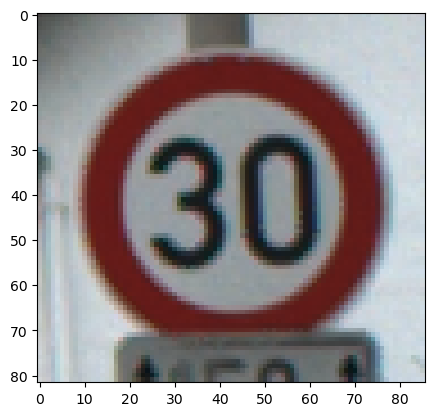

In [79]:
# Declare image path
path ='./test_images/00295.png'
# read in image
image_original = Image.open(path)
plt.imshow(image_original)

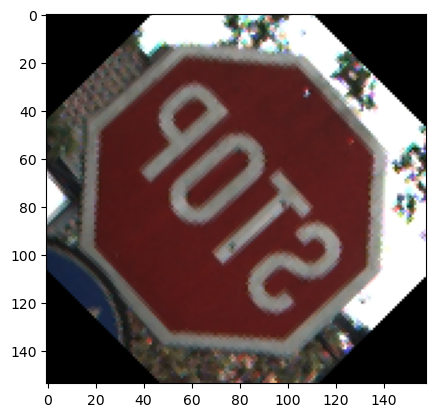

In [166]:
# Open the image
img_distort = Image.open("./test_images/00303.png")

# Rotate the image by n degrees
img_distort = img_distort.rotate(45)

# Flip the image horizontally
img_distort = img_distort.transpose(Image.FLIP_LEFT_RIGHT)

plt.imshow(img_distort)

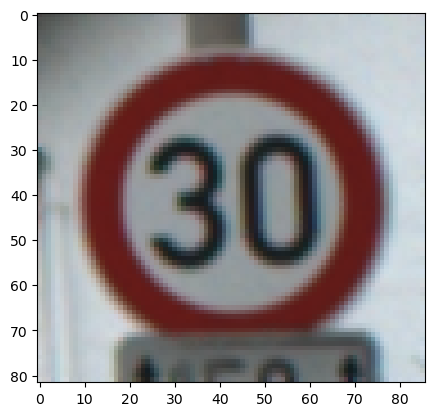

In [198]:
from PIL import Image, ImageEnhance

# Open image
img = Image.open('./test_images/00295.png')

# Create an instance of the ImageEnhance.Contrast class
enhancer = ImageEnhance.Sharpness(img)

# Adjust the contrast by a factor of 1.5
sharp_img = enhancer.enhance(0.05)
plt.imshow(sharp_img)


1/1 [==============================] - 0s 16ms/step
Top 5 predictions:
1. General caution with a probability of 93.49%
2. Ahead only with a probability of 5.01%
3. Right-of-way at intersection with a probability of 1.16%
4. Road work with a probability of 0.26%
5. Pedestrians with a probability of 0.06%


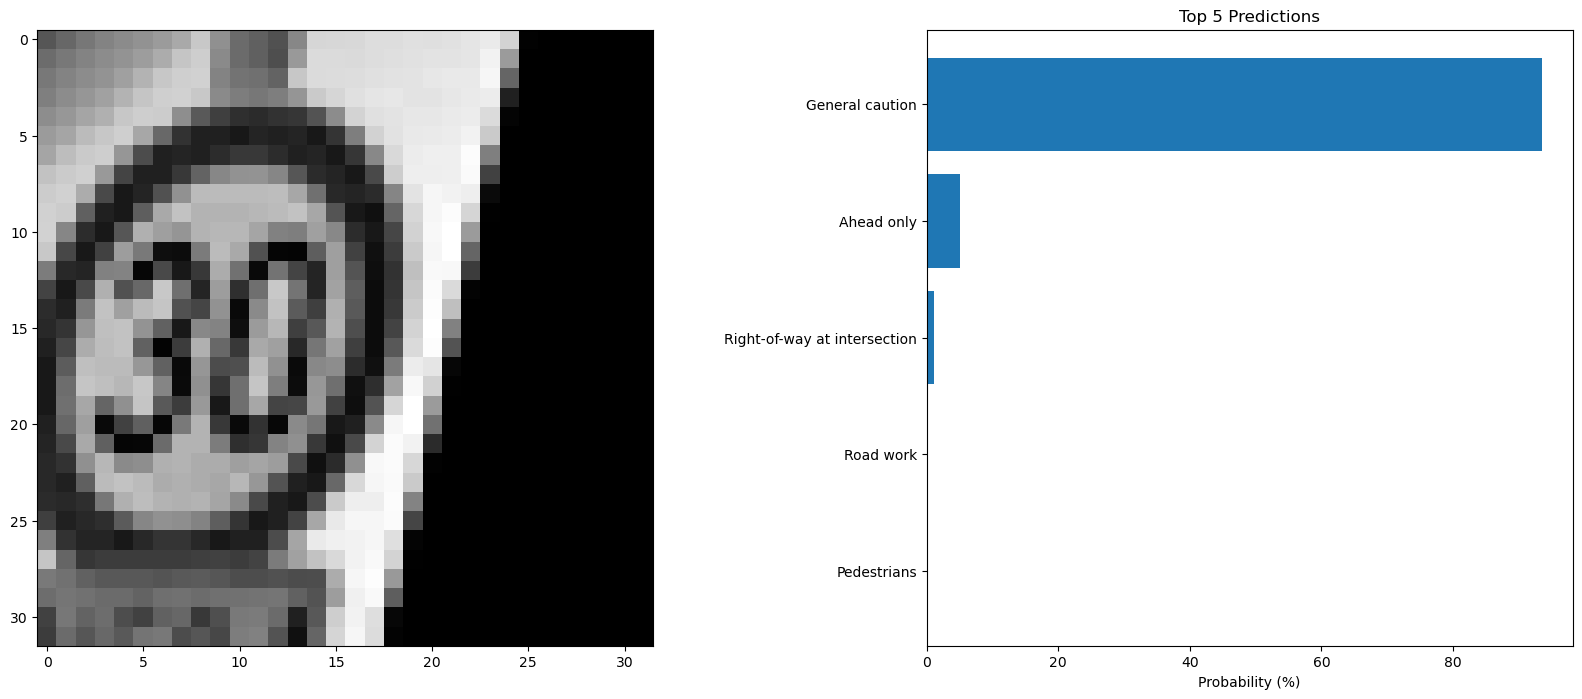

In [217]:
# function to predict single image
def classifyImage(im):
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,8))

    # resize image
    im = im.resize((32,32))
    
    ## REQUIRES NORMALIZATION
    img_arr = np.array(im)
    img_gray = cv2.cvtColor(img_arr,cv2.COLOR_RGB2GRAY)
    img_equ  = cv2.equalizeHist(img_gray)
    img_norm = img_equ/255 
    ax1.imshow(img_norm, cmap='gray')
    # reshape array to match the input shape of the model
    img_norm = np.expand_dims(img_norm, axis=0)
    img_norm = np.reshape(img_norm, (
    img_norm.shape[0], img_norm.shape[1], img_norm.shape[2],1))
    predicted = model_v3.predict(img_norm)[0]

    # display top predicted classes
    plt.title(f"Predicted class: {predicted}")
    # Get the top 5 predicted classes
    top_5_indices = np.argsort(predicted)[-5:][::-1] 
    # Get the corresponding class labels
    top_5_labels = [CLASS_LABELS[i] for i in top_5_indices]
    # get the probabilities of top 5 predictions in percentage
    top_5_probs = predicted[top_5_indices]* 100 

    # Plot a bar graph to disply percentages
    ax2.barh(top_5_labels, top_5_probs)
    ax2.set_title('Top 5 Predictions')
    ax2.set_xlabel('Probability (%)')
    ax2.invert_yaxis()
    fig.subplots_adjust(wspace=0.4)

    # Display the top 5 predictions
    print("Top 5 predictions:")
    for i in range(len(top_5_labels)):
        print(f"{i+1}. {top_5_labels[i]} with a probability of {top_5_probs[i]:.2f}%")
 
    
classifyImage(sheared_img)

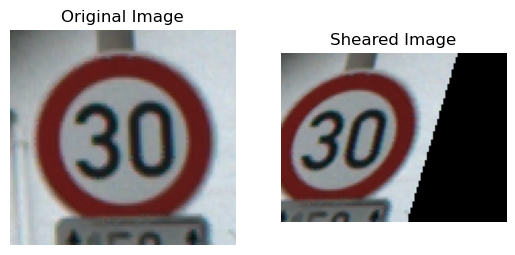

In [216]:
img = Image.open('./test_images/00295.png')

# Shear the image
shear_value = 0.3
width, height = img.size
sheared_img = img.transform((width + int(shear_value * height), height),
                             Image.AFFINE, (1, shear_value, 0, 0, 1, 0),
                             resample=Image.BICUBIC)

# Display the original and sheared images side by side
plt.subplot(1, 2, 1)
plt.imshow(np.array(img))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.array(sheared_img))
plt.title('Sheared Image')
plt.axis('off')

plt.show()